In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD, IncrementalPCA, MiniBatchSparsePCA
from sklearn.model_selection import train_test_split
import re
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import quantile_transform, FunctionTransformer, MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [2]:
df = pd.read_csv('../data/tb_data_team_homework.csv')
df['original_description'] = df['original_description'].apply(lambda s: re.sub('[^a-zA-Z]+', ' ', s).lower())
train, holdout = train_test_split(df, test_size=0.10, random_state=42)

array([[<AxesSubplot:title={'center':'amount'}>]], dtype=object)

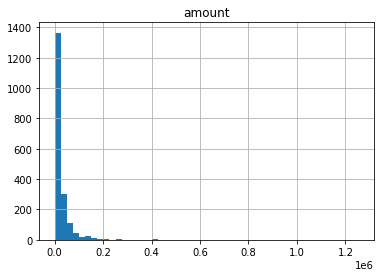

In [3]:
# Amount follows a power rule dist and would likely benefit from a log transform for clustering purposes

df.hist('amount', bins=50)

# Part 1

In [4]:
counter = HashingVectorizer()
    
count_matrix = counter.fit_transform(train.original_description.values)

svd = TruncatedSVD(n_components=10, n_iter=10, random_state=42)
transform = svd.fit_transform(count_matrix)

log_transformer = FunctionTransformer(np.log)
amounts = log_transformer.fit_transform(train.amount.values)
amounts = amounts.reshape(amounts.shape[0], -1)

X = np.append(transform, amounts, 1)
X = quantile_transform(X, n_quantiles=10, copy=True)
clusters = KMeans(n_clusters=20).fit_predict(X)

train['group'] = clusters
train.head(20)

<ipython-input-4-b1db884b7112>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['group'] = clusters


,original_description,amount,group
485,att payment nora indovina,106443,6
1610,withdraw comenity pay oh web pymt,9425,5
966,playstationnetw number,3427,7
1523,bestbuycomnumber,120722,18
32,instacart ca,14165,1
1559,prog county mut ins prem customer name xxxxxnu...,25491,0
1193,comcast,32343,18
915,google google storage,625,8
124,annual membership fee,29845,18
1888,annual membership fee,31102,18


Text(0, 0.5, 'Sum of squared distance')

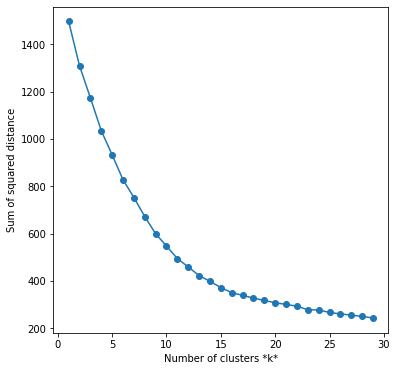

In [5]:
# For fun I made an elbow plot to answer: is there a more ideal number of clusters?
# Though there is no real clear elbow, 10-15 groups may be sufficient to group this data 

sse = []
list_k = list(range(1, 30))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X)
    sse.append(km.inertia_)

plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel('Number of clusters *k*')
plt.ylabel('Sum of squared distance')

In [6]:
train['group'].value_counts()

18    159
12    144
7     116
6     104
9     100
14     99
0      93
1      91
3      90
5      88
8      88
16     87
10     76
2      74
13     64
17     64
11     60
19     53
4      31
15     30
Name: group, dtype: int64

In [7]:
for i in range(20):
    print(train[train['group'] == i].head(5))

                                   original_description  amount  group
1559  prog county mut ins prem customer name xxxxxnu...   25491      0
298          direct withdrawal prog max ins co ins prem  141629      0
45         debit for acorns invest transfer co ref hash    3142      0
414   prog direct ins ins prem xxxxxnumber customer ...   22849      0
839                                ach debit planet fit   12252      0
                                   original_description  amount  group
32                                         instacart ca   14165      1
254   withdrawal debit card doordash dashpass www do...    3138      1
1780                        instacart httpsinstacar ca    34193      1
730                              playstationnetwork ca     1882      1
1041                          instacart httpsinstacarca   37969      1
                                   original_description  amount  group
931                       geico prem coll ppd id number   53630      2
1658  

In [22]:
val_counts = counter.transform(holdout.original_description.values)
val_transform = svd.transform(val_counts)
val_amounts = log_transformer.transform(holdout.amount.values)
val_amounts = val_amounts.reshape(val_amounts.shape[0], -1)
X_val = np.append(val_transform, val_amounts, 1)
quantile_transform(X_val, n_quantiles=10, copy=True)

X_train, X_test, y_train, y_test = train_test_split(X, train.group.values)

clf = MultinomialNB()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(f"acc = {metrics.accuracy_score(y_test, y_pred)}")
print(metrics.classification_report(y_test, y_pred))

acc = 0.7126168224299065


In [32]:
val_predictions = clf.predict(X_val)
holdout['class'] = val_predictions
holdout.head(50)

<ipython-input-32-2984e0b51ef7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holdout['class'] = val_predictions


,original_description,amount,class
1223,best buy el centro ca sale,11439,2
111,pos purchase progressive insurance oh number,21551,2
554,burger king west babylon ny,8181,2
526,payment to groupon inc,7650,2
1480,direct withdrawal acorns invest transfer,3669,2
1137,kindle svcs ne h ss,3380,2
70,comenity pay il des web pymt id pnumber indn c...,23562,5
251,prog direct ins des ins prem id xxxxxnumber cu...,57922,5
1315,gelsons via instacart,31372,2
1030,visa checking dnh godaddy com az date number c...,24545,2
